In [4]:
import numpy as np
def norm_zero_one_uint16(psf):
    return (((psf - psf.min()) / (psf.max() - psf.min())) * 255 * 255).astype(np.uint16)


[0.   0.   0.   0.   1.25 0.  ]
1446546.0 9838.681


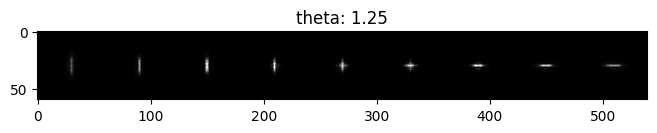

In [5]:
import jax.numpy as np
import jax
from data.visualise import grid_psfs, show_psf_axial

import matplotlib.pyplot as plt


class Simulator:
    
    xp = np
    acc = None
    N = 1024  # points to use in FFT
    pixel_size = 0.9  # camera pixel size
    zrange = 1.5  # distance either side of focus to calculate, in microns, could be arbitrary
    dz = 0.01  # step size in axial direction of PSF
    
    magnification = 120  # objective magnification
    ill_NA = 0.75  # numerical aperture at illumination beams
    det_NA = 1.1  # numerical aperture at sample
    n = 1.33  # refractive index at sample
    fwhmz = 3.0  # FWHM of light sheet in z

    ill_wavelength = 520  # illumination wavelength in nm
    det_wavelength = 570  # detection wavelength in nm


    def __init__(self):
        if self.acc == 3:
            self.xp = cp
#         np.random.seed(RANDOM_SEED)
        # self.seed(1234)  # set random number generator seed
        self.ill_wavelength = self.ill_wavelength * 1e-3
        self.det_wavelength = self.det_wavelength * 1e-3
        self.sigmaz = self.fwhmz / 2.355
        self.dx = self.pixel_size / self.magnification  # Sampling in lateral plane at the sample in um
        self.dxn = self.det_wavelength / (4 * self.det_NA)  # 2 * Nyquist frequency in x and y.
        self.Nn = int(np.ceil(self.N * self.dx / self.dxn / 2) * 2)  # Number of points at Nyquist sampling, even number
        self.dxn = self.N * self.dx / self.Nn  # correct spacing
        self.res = self.det_wavelength / (2 * self.det_NA)
        oversampling = self.res / self.dxn  # factor by which pupil plane oversamples the coherent psf data
        self.dk = oversampling / (self.Nn / 2)  # Pupil plane sampling
        self.k0 = 2 * np.pi * self.n / self.det_wavelength
        self.kx, self.ky = self.xp.meshgrid(self.xp.linspace(-self.dk * self.Nn / 2, self.dk * self.Nn / 2 - self.dk, self.Nn),
                                       self.xp.linspace(-self.dk * self.Nn / 2, self.dk * self.Nn / 2 - self.dk, self.Nn))
        self.kr = np.sqrt(self.kx ** 2 + self.ky ** 2)  # Raw pupil function, pupil defined over circle of radius 1.
        
        self.krmax = self.det_NA * self.k0 / self.n
        self.kr2 = self.kx ** 2 + self.ky ** 2
        self.csum = sum(sum((self.kr < 1)))  # normalise by csum so peak intensity is 1

        self.alpha = np.arcsin(self.det_NA / self.n)
        # Nyquist sampling in z, reduce by 10 % to account for gaussian light sheet
        self.dzn = 0.8 * self.det_wavelength / (2 * self.n * (1 - np.cos(self.alpha)))
        self.Nz = int(2 * np.ceil(self.zrange / self.dz))
        self.dz = 2 * self.zrange / self.Nz
        self.Nzn = int(2 * np.ceil(self.zrange / self.dzn))
        self.dzn = 2 * self.zrange / self.Nzn
        if self.Nz < self.Nzn:
            self.Nz = self.Nzn
            self.dz = self.dzn
        else:
            self.Nzn = self.Nz
            self.dzn = self.dz
        if (self.acc == 1) | (self.acc == 2):
            self._tdev = torch.device('cuda' if self.acc == 2 else 'cpu')

    
    def get_scalar_psf(self, zern_coefs=None):
        # use krmax to define the pupil function
        kx = self.krmax * self.kx
        ky = self.krmax * self.ky
        kr2 = (kx ** 2 + ky ** 2)  # square kr
        # 2 * np.pi * self.n / self.wavelength
        kz = self.xp.sqrt((self.k0 ** 2 - kr2) + 0j)
        psf = self.xp.zeros((self.Nzn, self.Nn, self.Nn))
        pupil = self.kr
#######################################################
# MODIFIED SECTION
        extra_aberration = np.zeros(self.kr.shape)
        print(kr2.sum(), (self.kr**2).sum())
        aberrations = np.array([
            np.ones(self.kr.shape), # piston
            2 * self.kx, # tip
            2 * self.ky, # tilt
            np.sqrt(3) * ((2 * (self.kr**2)) - 1), # defocus
            np.sqrt(6) * (self.kx**2 - self.ky ** 2), # oblique astigmatism
            2 * np.sqrt(6) * (self.kx * self.ky), # vertical astigmatism
            2 * np.sqrt(2) * (3 * self.kr**2 - 2) * self.kx, # vertical coma
            2 * np.sqrt(2) * (3 * self.kr**2 - 2) * self.ky, # horizontal coma
            2 * np.sqrt(2) * (3 * self.kr**2 - 4 * self.kr**2) * self.ky, # vertical trefoil 
            2 * np.sqrt(2) * (4 * self.kx**2 - 3 * self.kr**2) * self.kx, # oblique trefoil 
            np.sqrt(5) * (6 * self.kr**2 * (self.kr**2 - 1) + 1), # primary spherical
            np.sqrt(10) * (8 * self.kx**4 - 8 * self.kx**2 * self.ky**2 - (3 * self.kx ** 2)), # vertical secondary astigmatism
            np.sqrt(10) * (4 * self.kx * self.ky) * (4 * self.kx**2 + 4 * self.ky**2 - 3), # oblique secondary astigmatism
            np.sqrt(10) * (4 * self.kx * self.ky) * (4 * self.kx**2 + 4 * self.ky**2 - 3), # oblique secondary astigmatism
            np.sqrt(10) * ((self.kx**2 - self.ky**2) * (4*self.kx**2 - 3)) ** 2, # vertical quadrafoil
            np.sqrt(10) * ((2 * self.kx * self.ky) * (self.kx**2 - self.ky**2)) ** 2 # oblique quadrafoil
        ])
        if zern_coefs is not None:
            n_coefs = zern_coefs.shape[0]
            aberrations = aberrations[:n_coefs]
            extra_aberration = np.multiply(aberrations, zern_coefs[:, np.newaxis, np.newaxis]).sum(axis=0)
        else:
            extra_aberration = 0
        
#         if abb_mode == 1:
#             # piston       
#             extra_aberration = add_abb
#         elif abb_mode == 2:
#             # x tip
#             extra_aberration = self.kx * add_abb
#         elif abb_mode == 3:
#             # y tip
#             extra_aberration = self.ky * add_abb       
#         elif abb_mode == 4:
#             # defocus
#             extra_aberration = ((2 * (self.kr ** 2)) - 1) * add_abb
#         elif abb_mode == 5:
#             # Vertical astigmatism
#             extra_aberration = (self.kx ** 2 - self.ky ** 2) * add_abb
#         elif abb_mode == 6:
#             # Diagonal astigmatism       
#             extra_aberration = (self.kx * self.ky) * add_abb
#         elif abb_mode == 7:
#             # Coma x
#             extra_aberration = (3 * self.kr**2 - 2) * self.kx * add_abb
#         elif abb_mode == 8:
#             # Coma y
#             extra_aberration = (3 * self.kr**2 - 2) * self.ky * add_abb        
#         elif abb_mode == 9:
#             # Horizontal trefoil 
#             extra_aberration = (4 * self.kx**2 - 3 * self.kr**2) * self.kx * add_abb        
#         elif abb_mode == 10:
#             # Vertical trefoil 
#             extra_aberration = (3 * self.kr**2 - 4 * self.kr**2) * self.ky * add_abb     
#         elif abb_mode == 11:
#             # Spherical 
#             extra_aberration = (6 * self.kr**2 * (self.kr**2 - 1) + 1) * add_abb  
#         print(extra_aberration.shape if hasattr(extra_aberration, 'shape') else extra_aberration)
#         print(self.kr.shape)
#######################################################
        pupil = pupil < 1

        nz = 0
#         t1 = time.time()
#         for z in np.arange(-self.zrange, self.zrange - self.dzn, self.dzn):
#             c = (np.exp(1j * (extra_aberration + z * self.n * 2 * np.pi / self.det_wavelength *
#                       np.sqrt(1 - (self.kr * pupil) ** 2 * self.det_NA ** 2 / self.n ** 2)))) * pupil
#             psf = psf.at[nz, :, :].set(abs(np.fft.fftshift(np.fft.ifft2(c))) ** 2 * np.exp(-z ** 2 / 2 / self.sigmaz ** 2))
#             nz = nz + 1

        mult1 = self.n * 2 * np.pi / self.det_wavelength * np.sqrt(1 - (self.kr * pupil) ** 2 * self.det_NA ** 2 / self.n ** 2)
        zs = np.arange(-self.zrange, self.zrange, self.dzn)
        cs = jax.lax.map(lambda z: (np.exp(1j * (extra_aberration + (z * mult1)))) * pupil, zs)
        cs_psf = abs(np.fft.fftshift(np.fft.ifft2(cs), axes=(1,2))) ** 2
        psf = np.multiply(cs_psf, np.exp(-zs ** 2 / 2 / self.sigmaz ** 2)[:, np.newaxis, np.newaxis])

    
        # Normalised so power in resampled psf(see later on) is unity in focal plane
        psf = psf * self.Nn ** 2 / self.xp.sum(pupil) * self.Nz / self.Nzn
        return psf


s = Simulator()

phase = 1.25

import time

zerns = np.zeros((6,))
zerns = zerns.at[4].add(phase)
# zerns = zerns.at[3].add(phase)
print(zerns)
psf = s.get_scalar_psf(zern_coefs=zerns)

psf = norm_zero_one_uint16(psf)
show_psf_axial(psf, 'theta: ' + str(round(phase, 3)), 20)

psf_params = dict(res=90, zres=10, wl=570, na=0.95, ni=1.0, size=psf.shape[1], zsize=psf.shape[0])


In [ ]:
# # Simulate a PSF
# import numpy as np
# import matplotlib.pyplot as plt
# from data.visualise import grid_psfs, show_psf_axial

# from pyotf.otf import HanserPSF, apply_named_aberrations

# psf_params = dict(res=90, zres=10, wl=660, na=0.95, ni=1.0, size=64, zsize=250)

# psf = HanserPSF(**psf_params)
# psf = apply_named_aberrations(psf, {'vertical astigmatism': 0.5})

# psf = psf.PSFi

# psf *= 255 * 255
# psf = psf.astype(np.uint16)
# show_psf_axial(psf, '', 15)


In [ ]:
# Create a bead stack dataset

import numpy as np

n_psfs = 4

x = np.arange(0, psf_params['size']*n_psfs, psf_params['size'])
y = np.arange(0, psf_params['size']*n_psfs, psf_params['size'])

xx, yy = np.meshgrid(x, y)
xs = xx.flatten()
ys = yy.flatten()
coords = zip(xs, ys)

im_dim = x.max()+psf_params['size']+1
im_shape = (psf_params['zsize'], im_dim, im_dim)
# img = np.random.uniform(0, 0.005, size=im_shape)
img = np.zeros((im_shape))

psf_corner_min = 0
psf_corner_max = im_dim - psf_params['size'] - 1

# coords = np.random.randint(psf_corner_min, psf_corner_max, size=(n_psfs, 2))

for x,y in coords:
    tmp_psf = psf.copy()
    tmp_psf += np.random.randint(0, 5, size=tmp_psf.shape)
    img[:, x:x+psf_params['size'], y:y+psf_params['size']] += tmp_psf

plt.scatter(xs, ys)
plt.show()

In [ ]:
# Write bead stack data

import os
from tifffile import imread, imwrite
outpath = '/home/miguel/Projects/uni/data/smlm_3d/fake_bead_stack'
bead_stack_dir = os.path.join(outpath, 'bead_stack')
os.makedirs(bead_stack_dir, exist_ok=True)

bead_stack_path = os.path.join(bead_stack_dir, 'bead_stack.ome.tif')
imwrite(bead_stack_path, img.astype(np.uint16))

im_slice = img[psf_params['zsize']//2]
slice_path = bead_stack_path.replace('.ome', '_slice.ome')
imwrite(slice_path, im_slice.astype(np.uint16))
print(img.shape)
print(im_slice.shape)

In [ ]:
plt.imshow(im_slice)
plt.show()

In [ ]:
# Run picasso on bead stack
!picasso localize -b 31 -d 0 -px {int(psf_params['res'])} {slice_path}

spots_path = slice_path.replace('.ome.tif', '.ome_spots.hdf5')
locs_path = slice_path.replace('.ome.tif', '.ome_locs.hdf5')

In [ ]:
import h5py
bead_path = slice_path.replace('.tif', '_spots.hdf5')
with h5py.File(bead_path, 'r') as f:
    d = np.array(f['spots'])
show_psf_axial(d, '', 1)

In [ ]:
# Run simulation here

In [12]:
import yaml
import os

class SafeLoaderIgnoreUnknown(yaml.SafeLoader):
    def ignore_unknown(self, node):
        return None 

SafeLoaderIgnoreUnknown.add_constructor(None, SafeLoaderIgnoreUnknown.ignore_unknown)

fname = 'nanopore'
grid_pairs_dir = f'/home/miguel/Projects/uni/data/smlm_3d/fake_bead_stack/{fname}/'
grid_pairs_img = os.path.join(grid_pairs_dir, fname + '.raw')
yaml_file = grid_pairs_img.replace('.raw', '.yaml')

with open(yaml_file, 'r') as f:
    txt = yaml.load(f, Loader=SafeLoaderIgnoreUnknown)
with open(yaml_file, 'w') as f:
    yaml.dump(txt, f)

!picasso localize -b 31 -d 0 -g 2000 -px {int(psf_params['res'])} {grid_pairs_img}
nanopore_locs = grid_pairs_img.replace('.raw', '_locs.hdf5')
nanopore_spots = grid_pairs_img.replace('.raw', '_spots.hdf5')

    ____  _____________   __________ ____ 
   / __ \/  _/ ____/   | / ___/ ___// __ \
  / /_/ // // /   / /| | \__ \\__ \/ / / /
 / _____/ // /___/ ___ |___/ ___/ / /_/ / 
/_/   /___/\____/_/  |_/____/____/\____/  
                                          
Localize - Parameters:
No       Label           Value     
1        command         localize  
2        files           /home/miguel/Projects/uni/data/smlm_3d/fake_bead_stack/nanopore/nanopore.raw
3        box_side_length 31        
4        fit_method      mle       
5        gradient        2000      
6        drift           0         
7        roi             None
8        baseline        0         
9        sensitivity     1         
10       gain            1         
11       qe              1         
12       mf              0         
13       pixelsize       90        
14       zc                        
15       suffix                    
16       database        0         
------------------------------------------
Name

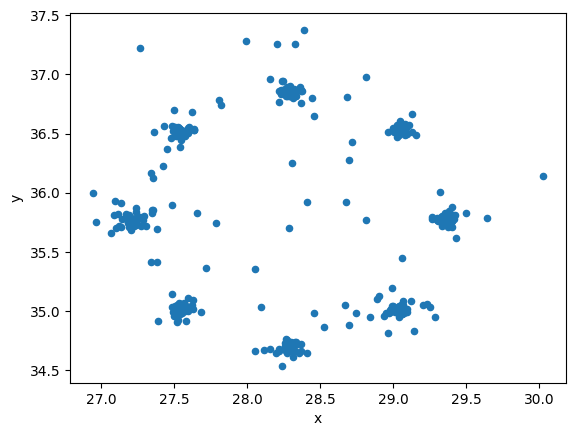

In [13]:
import pandas as pd
df = pd.read_hdf(grid_pairs_img.replace('.raw', '_locs.hdf5'), key='locs')
df.plot.scatter(x='x', y='y')
plt.show()

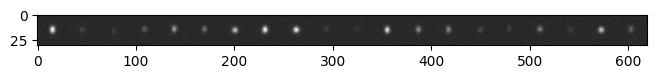

In [14]:
import h5py
with h5py.File('/home/miguel/Projects/uni/data/smlm_3d/fake_bead_stack/nanopore/nanopore_spots.hdf5') as f:
    spots = np.array(f['spots'])
show_psf_axial(spots, '', 15)

In [ ]:
yaml_config = {
    'bead_stack': {
        'type': 'smlm_z.extras.datasets.TiffDataSet',
        'filepath': bead_stack_path,
    },
    'spots': {
        'type': 'smlm_z.extras.datasets.SpotsDataSet',
        'filepath': spots_path,
        'key': 'spots'
    },
    'locs': {
        'type': 'pandas.HDFDataSet',
        'filepath': locs_path,
        'key': 'locs'
    },
    'nanopore_locs': {
        'type': 'pandas.HDFDataSet',
        'filepath': nanopore_locs,
        'key': 'locs'
    },
    'nanopore_spots': {
        'type': 'smlm_z.extras.datasets.SpotsDataSet',
        'filepath': nanopore_spots,
        'key': 'spots'
    },
}
for k, v in yaml_config.items():
    try:
        assert os.path.exists(v['filepath'])
    except AssertionError as e:
        print(v['filepath'], 'does not exist')
        break

import sys
yaml.dump(yaml_config, sys.stdout)

In [ ]:
import pandas as pd
import seaborn as sns
from collections import Counter

df = pd.read_csv('/home/miguel/Projects/uni/phd/smlm_z/smlm-z/tmp.csv')
df['cluster_id'] = df['cluster_id'].astype(str)
sns.scatterplot(data=df, x='x', y='y', hue='cluster_id')
Counter(df['cluster_id'])

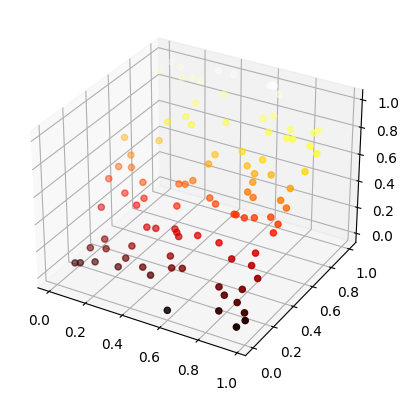

In [16]:
import numpy as _np
xyz = _np.random.uniform(0, 1, size=(100, 3))
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xs, ys, zs = xyz[:, 0], xyz[:, 1], xyz[:, 1]
cmap = plt.get_cmap("hot")
ax.scatter(xs, ys, zs, c=zs, cmap=cmap)